# Credit Card Fraud Detection Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import tensorflow as tf

In [2]:
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE


In [3]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential

In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [12]:
df = pd.read_csv("Credit Card Transactions.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [13]:
df.shape

(284617, 31)

In [15]:
df.isnull().values.any()

True

### Checking number of records of each kind of transaction class (Fraud and Non-Fraud)

C:\Users\shubh\AppData\Local\Temp\ipykernel_42532\3573906420.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

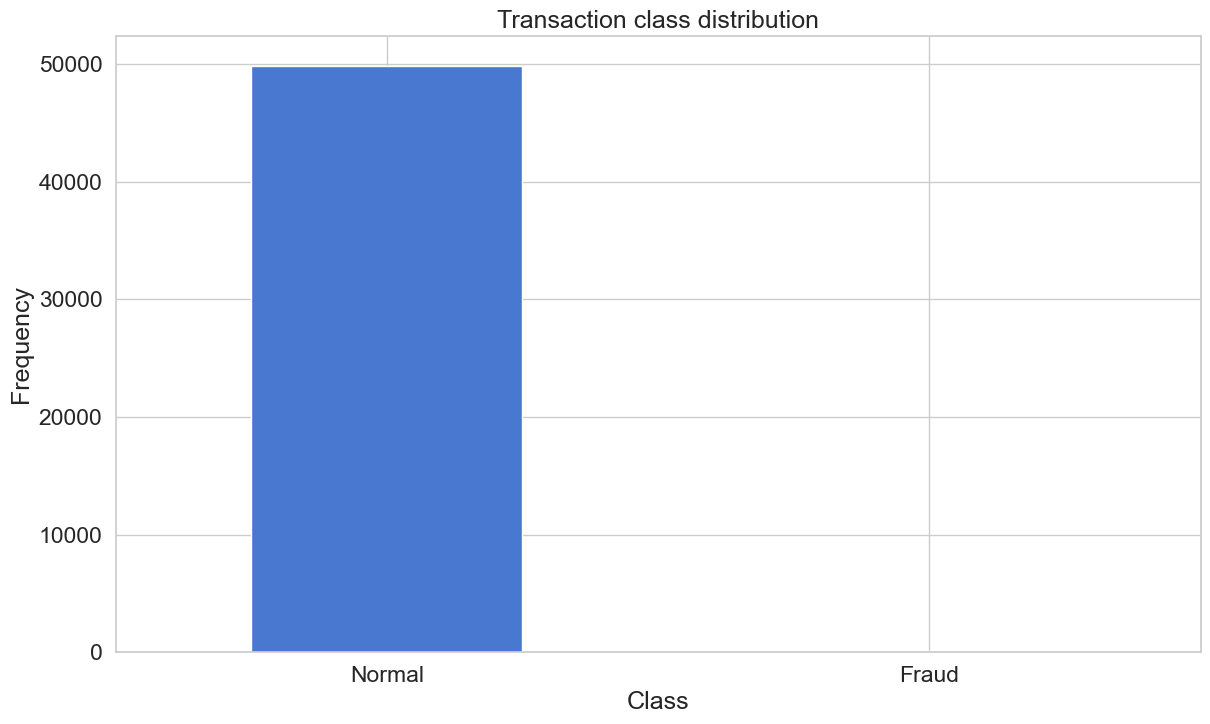

In [16]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

### Checking the amount of money involved in each kind of transaction

In [17]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print(frauds.shape)
print(normal.shape)

(148, 31)
(49851, 31)


In [18]:
frauds.Amount.describe()

count     148.000000
mean      100.170676
std       233.347471
min         0.000000
25%         1.000000
50%         9.560000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [19]:
normal.Amount.describe()

count    49851.000000
mean        93.241144
std        253.068147
min          0.000000
25%          7.680000
50%         25.000000
75%         85.060000
max      12910.930000
Name: Amount, dtype: float64

###  Visualizing Differences

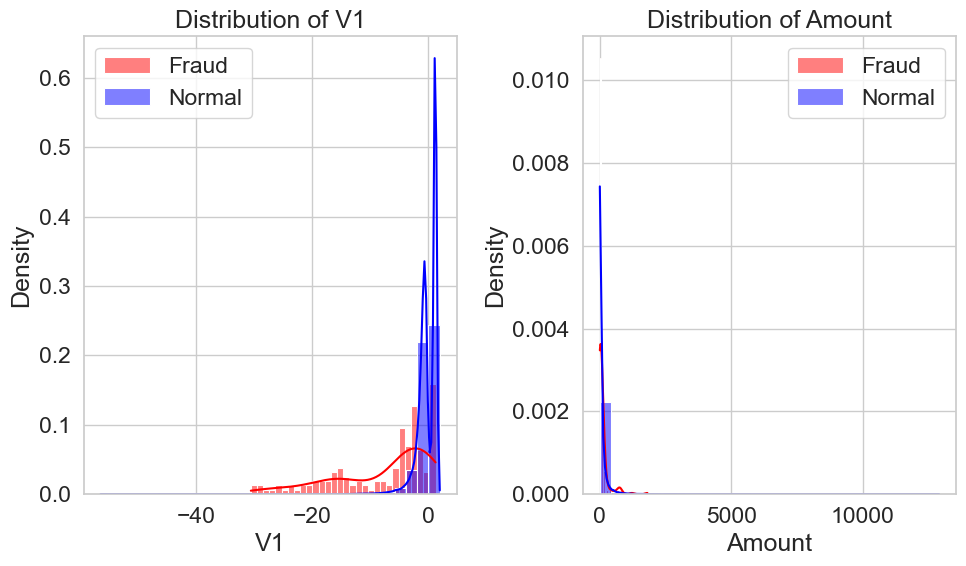

In [20]:
plt.figure(figsize=(10, 6))

# Plotting V1
plt.subplot(1, 2, 1)
sns.histplot(frauds['V1'], color='red', label='Fraud', kde=True, stat='density', bins=30)
sns.histplot(normal['V1'], color='blue', label='Normal', kde=True, stat='density', bins=30)
plt.title('Distribution of V1')
plt.legend()

# Plotting Amount
plt.subplot(1, 2, 2)
sns.histplot(frauds['Amount'], color='red', label='Fraud', kde=True, stat='density', bins=30)
sns.histplot(normal['Amount'], color='blue', label='Normal', kde=True, stat='density', bins=30)
plt.title('Distribution of Amount')
plt.legend()

plt.tight_layout()
plt.show()

### Graphical representation of Amount

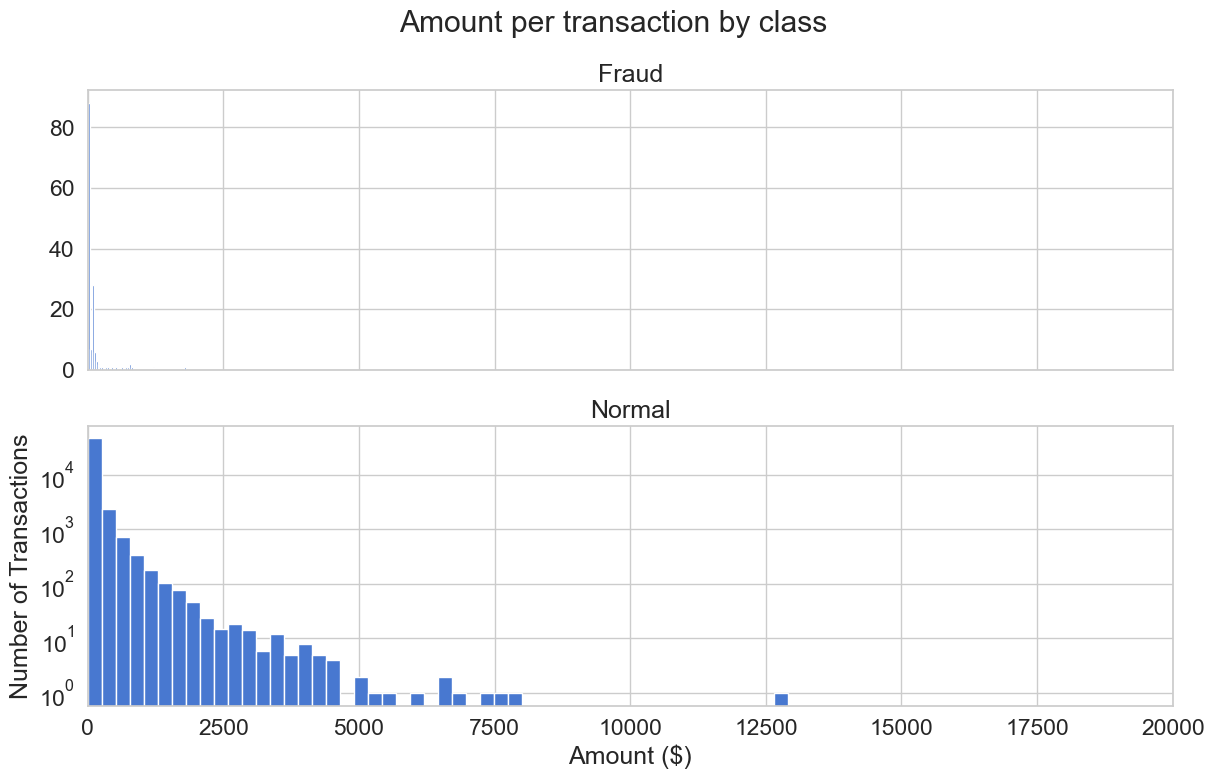

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

### Plotting time of transaction to check for correlations

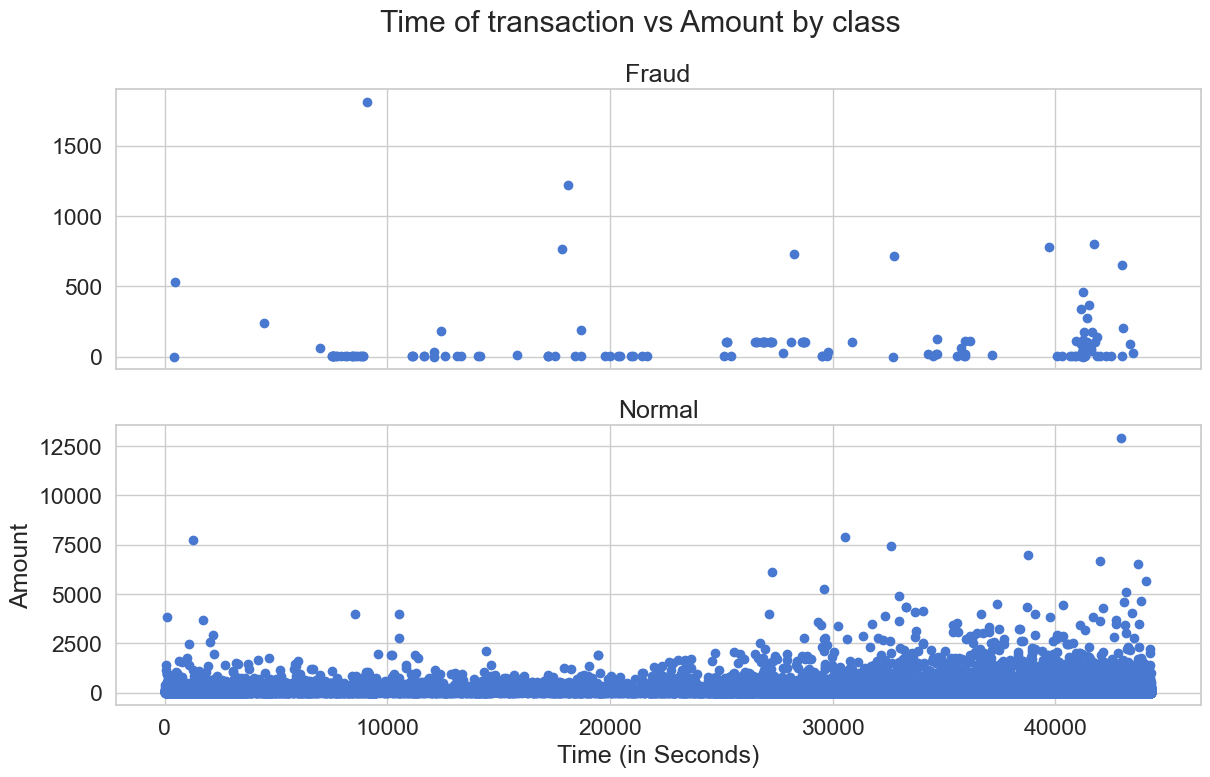

In [22]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [23]:
data = df.drop(['Time'], axis=1)

In [24]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


### Scaling the Amount using StandardScaler

In [25]:
from sklearn.preprocessing import StandardScaler

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

### Building the Model

In [26]:
non_fraud = data[data['Class'] == 0] #.sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud._append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

### Spiting the data into 80% training and 20% testing

In [27]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train_fraud = X_train[X_train.Class == 1]
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(39910, 29)

### Autoencoder Model

In [28]:
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

  ###  Training the credit card fraud detection model

In [29]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

### Scaling the values

In [30]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.0335 - val_loss: 0.9161
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0326 - val_loss: 0.9156
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0321 - val_loss: 0.9151
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0317 - val_loss: 0.9146
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0311 - val_loss: 0.9141
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0301 - val_loss: 0.9136
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0298 - val_loss: 0.9130
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0297 - val_loss: 0.9125
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0287 - val_loss: 0.9120
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0282 - val_loss: 0.9114


### Obtain the Hidden Representation

In [31]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

### Model Prediction

In [32]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


### Getting the representation Data

In [33]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

### Credit Card Fraud Detection Prediction Model

In [34]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

In [35]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       758
         1.0       1.00      0.59      0.74        29

    accuracy                           0.98       787
   macro avg       0.99      0.79      0.87       787
weighted avg       0.98      0.98      0.98       787


Accuracy Score:  0.9847522236340533


##### In conclusion, the training process established a solid foundation for fraud detection, but ongoing refinement is recommended to optimize fraud detection sensitivity and reduce false negatives.